# Task 4 Time Series Analysis
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to extract the time series


In [27]:
import numpy as np
import math
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv("../dataset/cleaned_joined_tweets.csv", index_col = 0) 
del df['lang']
del df['text']
del df['created_at_user']
del df['statuses_count']
del df['id'] #of the tweet

In [3]:
df.created_at = pd.to_datetime(df.created_at, errors='ignore').astype('datetime64[D]')
df.sort_values(by=['user_id', 'created_at'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11277758 entries, 4499433 to 4080317
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   retweet_count   int64         
 2   reply_count     int64         
 3   favorite_count  int64         
 4   num_hashtags    int64         
 5   num_urls        int64         
 6   num_mentions    int64         
 7   created_at      datetime64[ns]
 8   bot             int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 860.4 MB


Get only the tweets in 2019:

In [4]:
min_date = np.datetime64('2019-01-01 00:00:00')
max_date = np.datetime64('2019-12-31 23:59:59')

df_2019 = df[(df.created_at > min_date) & (df.created_at < max_date)].copy()

For each user we define a series of 365 values initialized at -1, so we define a dataframe of Number_of_users * 365

In [5]:
df_2019.head()

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,bot
3343007,722623,1,0,0,0,0,2,2019-01-03,0
3343357,722623,0,0,2,0,0,0,2019-01-03,0
3343475,722623,0,0,0,0,0,0,2019-01-03,0
3343674,722623,0,0,0,0,0,0,2019-01-03,0
3344173,722623,3,0,0,0,0,1,2019-01-03,0


## Extract timeseries

### Use pivoting

In [6]:
user_2019_bot = df_2019[['user_id', 'bot']].copy()
user_2019_bot.drop_duplicates(inplace=True)
user_2019_bot.set_index('user_id', inplace=True)

In [7]:
user_2019 = df_2019.groupby(['user_id', 'created_at']).sum()

Is possible to perform the following operation, since in the data cleaning we filled the NaN values.

In [8]:
user_2019['success_score'] = (user_2019.retweet_count + user_2019.reply_count + user_2019.favorite_count) / (user_2019.num_hashtags + user_2019.num_urls + user_2019.num_mentions + 0.1)

Deleting the columns used for the calculation

In [9]:
del user_2019['retweet_count']
del user_2019['reply_count']
del user_2019['favorite_count']
del user_2019['num_hashtags']
del user_2019['num_urls']
del user_2019['num_mentions']

In [10]:
user_2019 = user_2019.pivot_table('success_score','created_at','user_id')
user_2019.rename_axis(columns=None, inplace=True)
user_2019.reset_index(drop=False, inplace=True)

In [11]:
dates = pd.Series(pd.date_range('01-01-2019','31-12-2019')).rename('created_at')

user_2019 = user_2019.merge(dates, how='outer', on='created_at')
user_2019.fillna(-1, inplace=True)
user_2019.set_index('created_at', inplace=True)
user_2019.sort_index(inplace=True)

In [12]:
user_2019.head()

,722623,755746,806975,887281,1382561,3888491,5812422,5820222,6296742,6775342,...,2654027174,2658726517,2662897087,2675560628,2680793168,2682782132,2688868016,2711226669,2717999764,2722021425
created_at,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-02,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-03,1.549296,0.0,-1.0,0.0,60.094007,0.0,0.10989,68.395062,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-04,1626.393443,0.0,-1.0,-1.0,0.448065,-1.0,4.83871,575.742574,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-05,1.818182,0.0,-1.0,-1.0,0.370370,-1.0,0.00000,0.000000,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [13]:
user_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Columns: 6787 entries, 722623 to 2722021425
dtypes: float64(6787)
memory usage: 18.9 MB


In [2]:
user_2019.to_csv('../dataset/time_series.csv')

NameError: name 'user_2019' is not defined

## Preprocessing

In [28]:
user_2019 = pd.read_csv('../dataset/time_series.csv', index_col=0)

In [29]:
user_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2019-01-01 to 2019-12-31
Columns: 6787 entries, 722623 to 2722021425
dtypes: float64(6787)
memory usage: 18.9+ MB


### Detect and Remove trends

We will use Augmented Dickey-Fuller test to check stationarity or non-stationarity of timesieres. We find all timeseries that are not stationary using a threshold of 0.05 on the returned p-value.

In [30]:
non_stationary_idx_list = []

with warnings.catch_warnings(record=True):

    for col in tqdm(user_2019.columns):
        adf = adfuller(user_2019[col])
        pvalue = adf[1]
        if pvalue > 0.05:
            non_stationary_idx_list.append(col)

100%|██████████| 6787/6787 [01:35<00:00, 71.24it/s]


About 1/6 of the timeseries contains trends to be removed.

In [31]:
len(non_stationary_idx_list)

1142

Perform Augmented Dickey-Fuller test of an example non sationary timeseries (found before).

In [32]:
ts_example = user_2019[non_stationary_idx_list[4]] # Example ts


adf = adfuller(ts_example)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -1.7545213490167
p-value: 0.4032626809902452
Critical values:
1%: -3.448905534655263
5%: -2.8697161816205705
10%: -2.5711258103550882


Detrend example timeseries

In [33]:
ts_example_detrend = ts_example - ts_example.rolling(window=12, min_periods=1).mean()

Plot original and detrended timeseries.

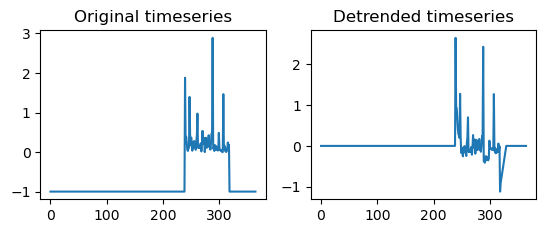

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3/4)


ax2.plot(ts_example_detrend.to_numpy())
ax2.set_title('Detrended timeseries')
ax2.set_box_aspect(3/4)

plt.show()

Perform Augmented Dickey-Fuller test of example of timeseries **after** trend removal

In [35]:
adf = adfuller(ts_example_detrend)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -5.534207730475927
p-value: 1.75968091780411e-06
Critical values:
1%: -3.448905534655263
5%: -2.8697161816205705
10%: -2.5711258103550882


Remove trends for all timeseries found be non-stationary.

In [36]:
user_2019_detrend = user_2019.copy()

for col in non_stationary_idx_list:
    user_2019_detrend[col] = user_2019_detrend[col] - user_2019_detrend[col].rolling(window=12, min_periods=1).mean()

In [37]:
user_2019_detrend.to_csv('../dataset/time_series_trendless.csv')

### Noise detection

To find the best sliding window for the noise we used the mean of the **sums of absolute differences (SAD)** between the original timeseries and the smoothed one, then we resorted to the elbow method to choose the best window that 'doesn't smooth too much' the original timeseries.

In [38]:
noise_windows = np.array(range(1,21))

# Dict for all window sizes
mean_sad_dict = dict()

for window_size in tqdm(noise_windows):
    sum_abs_diff_users = list()

    for user_id in user_2019_detrend.columns:
        # Calculate SAD for each user
        sum_abs_diff_single_per_user = np.sum(np.abs(user_2019_detrend[user_id].rolling(window=window_size, center = True, min_periods = 1).mean() - user_2019_detrend[user_id]))
        sum_abs_diff_users.append(sum_abs_diff_single_per_user)
    
    # Average the SAD for all users to get final SAD score
    mean_sad_dict[window_size] = np.average(sum_abs_diff_users)

100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


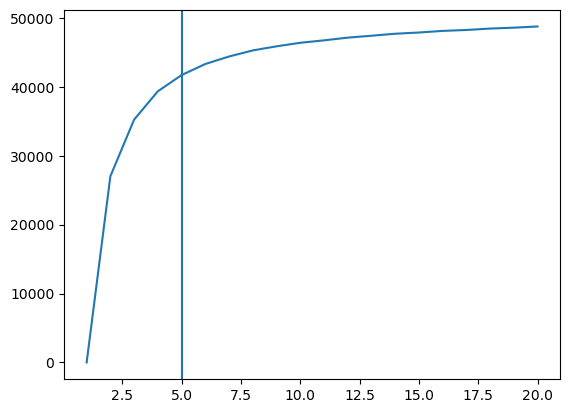

In [39]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(5)
plt.show()

The result of this analisys is window size = 5

In [40]:
window_size = 5

In [41]:
# Function that denoises df of timeseries given a window size
def denoiser(df, window_size):
    denoised_df = df.apply(lambda ts : ts.rolling(window=window_size, center = True, min_periods = 1).mean())

    return denoised_df

Apply the denoising function to all timeseries.

In [42]:
user_2019_denoised = denoiser(user_2019_detrend, window_size=window_size)


Plot an example timeseries before and after denoising.

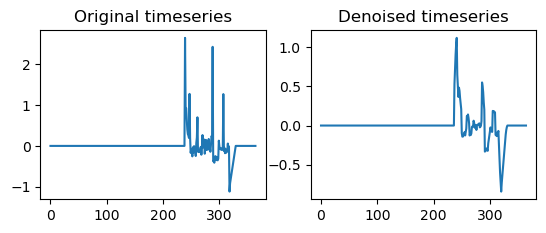

In [43]:
ts_example = user_2019_detrend[non_stationary_idx_list[4]]
ts_example_denoised = user_2019_denoised[non_stationary_idx_list[4]]

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3/4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3/4)


plt.show()

### Scaler with mean and std

Normalize the timeseries using Z-score normalization (mean and std)

In [44]:
# Apply normalization
user_2019_std = pd.DataFrame(columns=user_2019_denoised.columns)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  
for col in user_2019_denoised.columns:
    user_2019_std[col] = scaler.fit_transform(user_2019_denoised[col].values.reshape(1, -1)).flatten()

Show some examples of normalized timeseries.

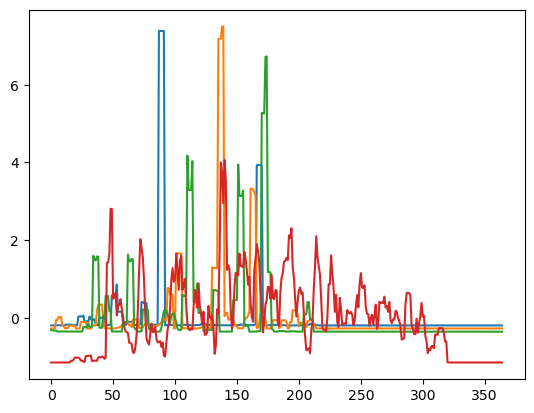

In [45]:
ts_example_1 = user_2019_std.iloc[:, 29]
ts_example_2 = user_2019_std.iloc[:, 567]
ts_example_3 = user_2019_std.iloc[:, 1000]
ts_example_4 = user_2019_std.iloc[:, 867]
plt.plot(ts_example_1.to_numpy())
plt.plot(ts_example_2.to_numpy())
plt.plot(ts_example_3.to_numpy())
plt.plot(ts_example_4.to_numpy())
plt.show()

Define the final dataset containing the preprocessed timeseries. Use transpose to have a timeseries for each row.

In [46]:
timeseries_data = np.transpose(user_2019_std.values)

## Clustering timeseries

In [47]:
def print_clusters(y, K, model):
    print("k = ", K, "| Clusters =", np.unique(y,return_counts=True)[1], "| Inertia =", model.inertia_)

In [215]:
# Function that plots sample of timeseries for each cluster

def plot_timeseries_per_cluster(labels, n_clusters):
    fig, ax = plt.subplots(math.ceil(n_clusters/2), 2)
    print(np.shape(ax))
    colors = plt.rcParams["axes.prop_cycle"]()
    fig.set_size_inches(8, 8)


    max_num_samples_per_cluster = 5
    for c in range(n_clusters):
        cluster_index = [i for i, x in enumerate(labels) if x == c] 
        random_indexes = np.random.choice(
            cluster_index, size=min(len(cluster_index), max_num_samples_per_cluster), replace=False)
        cluster_sample = timeseries_data[random_indexes]
        
        ax_idx_row = math.ceil(c/2)-1
        ax_idx_col = c % 2
        ax_c = ax[ax_idx_row][ax_idx_col]
        color = next(colors)["color"]
        ax_c.set_title('Cluster: '+str(c), y=1.0, pad=-14)
        for ts in cluster_sample:
            ax_c.plot(ts, color=color)

    plt.show()

### Shape-Based clustering
#### K-Means

In [48]:
from tslearn.clustering import TimeSeriesKMeans

Use euclidean metric

In [49]:
with warnings.catch_warnings(record=True):
    # Define lists of the K values for euclidean kmeans
    inertia_euclidean = list()
    models_euclidean = list()

    metric = 'euclidean'
    print("Clusters sizes for each K with", metric, "metric:")

    for n_clusters in range(2, 21):
        # Build and fit Kmeans
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=10)
        model.fit(timeseries_data)
        y = model.predict(timeseries_data)
        # Print cluster and inertia info
        print_clusters(y, n_clusters, model)

        inertia_euclidean.append(model.inertia_)
        models_euclidean.append(model)

Clusters sizes for each K with euclidean metric:
k =  2 | Clusters = [3284 3503] | Inertia = 248.30505727184908
k =  3 | Clusters = [1191 2121 3475] | Inertia = 241.5006118606958
k =  4 | Clusters = [2844 1178  659 2106] | Inertia = 231.51233428869065
k =  5 | Clusters = [ 995 2478  324 1908 1082] | Inertia = 225.30810684150657
k =  6 | Clusters = [ 661  499 1900  767  337 2623] | Inertia = 221.63063069263478
k =  7 | Clusters = [1787 2789  902  228  441  272  368] | Inertia = 211.34908992845592
k =  8 | Clusters = [ 307  333 2559  270  366  196 1847  909] | Inertia = 207.10947943360983
k =  9 | Clusters = [2791  273  183  233  446  463  720  341 1337] | Inertia = 205.04208802491516
k =  10 | Clusters = [1877  186  285  226  852  464 1018 1351  210  318] | Inertia = 197.7875288213722
k =  11 | Clusters = [ 363 1991  300  184 1538  270  337  280  224 1107  193] | Inertia = 197.63213143012422
k =  12 | Clusters = [ 289 1845  266  300  338  999  192  318  650 1019  366  205] | Inertia = 1

Now we plot the inertia curves of Kmeans with euclidean metrics to help the choice of the best K.

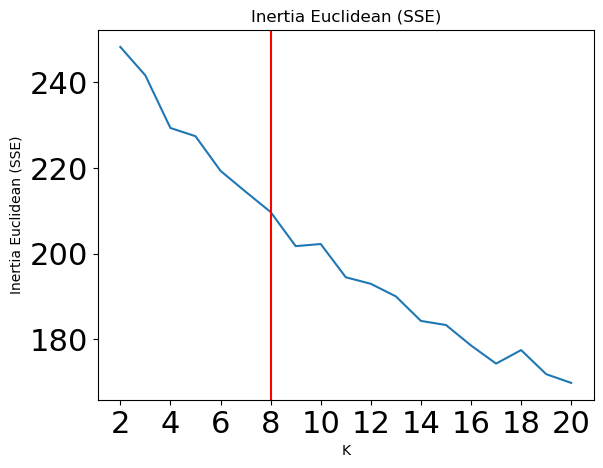

In [50]:
# Plot SSE with euclidean metric
plt.plot(range(2, len(inertia_euclidean) + 2), inertia_euclidean)
plt.ylabel('Inertia Euclidean (SSE)')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(np.arange(2,21,2))
plt.title('Inertia Euclidean (SSE)')
plt.axvline(8, color='r')
plt.show()

We choose K=8 as the best kmeans with euclidean metric, as, even it there is no clear elbow in the curve, it is a balanced number of clusters in terms of SSE and cluster sizes.

In [51]:
euclidean_n_clusters = 8
euclidean_kmeans = models_euclidean[euclidean_n_clusters-2]

(4, 2)


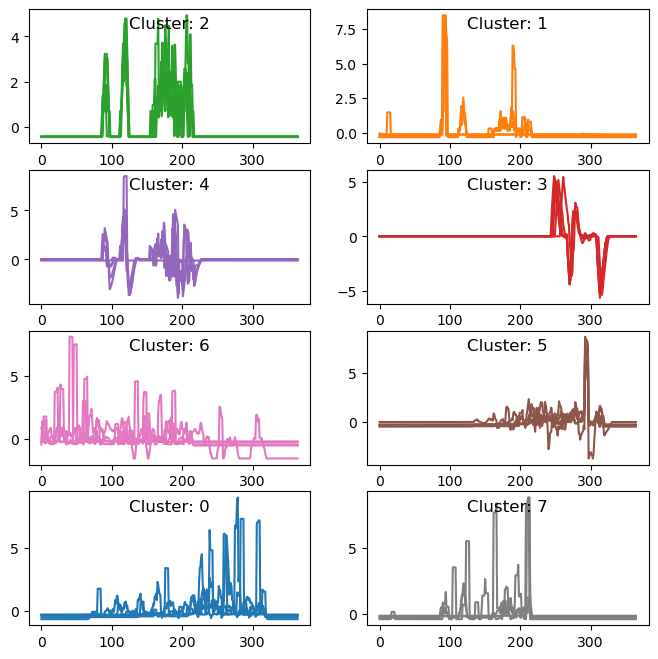

In [54]:
plot_timeseries_per_cluster(euclidean_kmeans.labels_, euclidean_n_clusters)

We can see that the major differences in the clusters are in the positions of peaks and pits in the timeseries.

Use same number of clusters of best K-means with euclidean metric to run K-means with **DTW** metric (too computationally expensive to try all K values).

In [101]:
metric = 'dtw'
dtw_n_clusters = 8

In [97]:
model = TimeSeriesKMeans(n_clusters=dtw_n_clusters, metric=metric, max_iter=10)
model.fit(timeseries_data)
y = model.predict(timeseries_data)
# Print cluster and inertia info
print("Clustering info for KMeans with", metric, "metric")
print_clusters(y, 8, model)

inertia_dtw = model.inertia_
model_dtw = model

c:\Users\giaco\anaconda3\envs\PythonGPU\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Clustering info for KMeans with dtw metric
k =  8 | Clusters = [2246 1294  336  566  892  531  284  638] | Inertia = 31.78216609707434


Now we show the timeseries for each cluster

(4, 2)


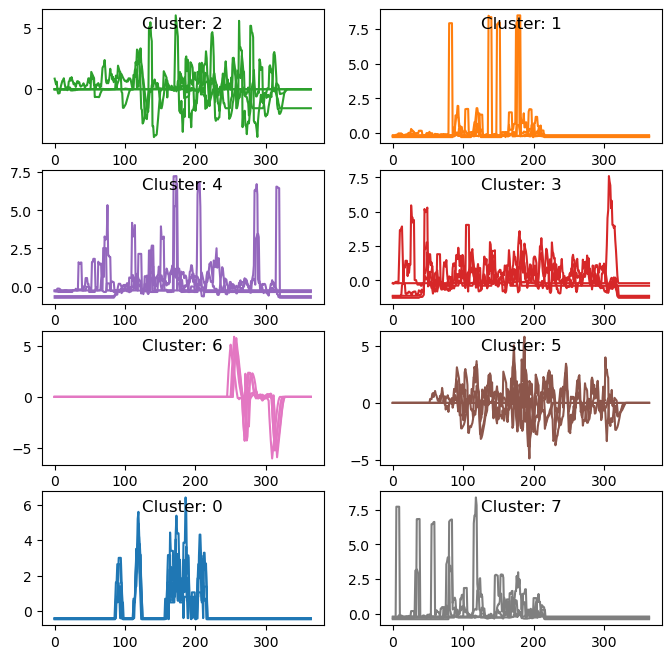

In [103]:
plot_timeseries_per_cluster(model_dtw.labels_, dtw_n_clusters)

DTW KMeans is similar to euclidean kmeans (some clusters seems to be equal such as DTW cluster 6 and euclidean cluster 3), but there are less clusters whcih have spikes in same positions.

### Feature based clustering

In [104]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [105]:
def calculate_features(values):
    # Define a set of features to extract from the timeseries
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

Extract features from timeseries

In [106]:
timeseries_features = [list(calculate_features(x).values())[:-2] for x in timeseries_data]

#### K-Means

Use minmax normalization for KMeans.

In [107]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(timeseries_features)

In [108]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [109]:
# Params for kmeans
clusters_list = [x for x in range(2, 20)]
init_value = 10
iter_value = 300

# Get list of kmeans with from the list of possible k
kmeans_list = KMeansFunction (X_minmax, clusters_list, init_value, iter_value)

# Calculate SSE for each kmeans
sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)

100%|██████████| 18/18 [00:09<00:00,  1.86it/s]

k =  2 | Clusters = [3478 3309] | Inertia = 802.2929151643842
k =  3 | Clusters = [3139  471 3177] | Inertia = 557.3921870619587
k =  4 | Clusters = [3114 2542  700  431] | Inertia = 423.79503941498007
k =  5 | Clusters = [1835 1962  360 1935  695] | Inertia = 346.1633925347554
k =  6 | Clusters = [1609 1862  284 1843  495  694] | Inertia = 302.22613959548386
k =  7 | Clusters = [1640 1199  283 1266  691 1270  438] | Inertia = 273.2422276238821
k =  8 | Clusters = [ 954 1619  682  415 1257  727  851  282] | Inertia = 255.41777230707973
k =  9 | Clusters = [ 744  964  478 1254  671  282  895 1123  376] | Inertia = 233.9841038988017
k =  10 | Clusters = [ 886  650  164  161  479  969 1123  738 1246  371] | Inertia = 219.24830864028542
k =  11 | Clusters = [1193  652  148  709  911  130 1081  474  936  371  182] | Inertia = 203.59435784543672
k =  12 | Clusters = [ 872  505  183  653  628  909  945  138 1004  371  451  128] | Inertia = 191.53632565120736
k =  13 | Clusters = [761 795 169 

Now we plot the SSE curve to help the choice of the best K.

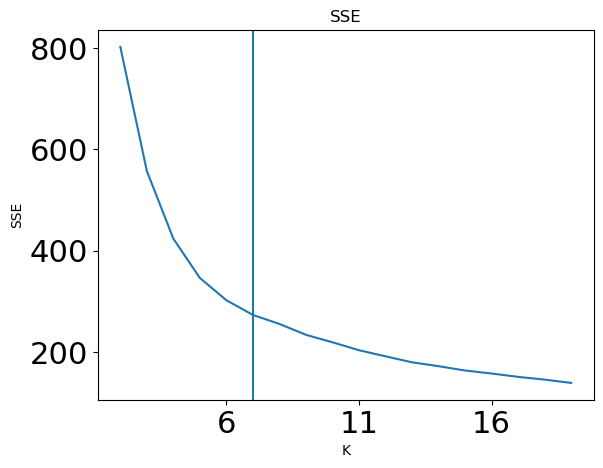

In [110]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(7)
plt.show()

In this case we choose K = 7 as we can deduct from the knee method. We can also see during the execution that from K=>7, there are 3 big clusters.

In [111]:
best_n_clusters = 7
best_kmeans = kmeans_list[best_n_clusters-2]

Now we show the timeseries for each cluster

(4, 2)


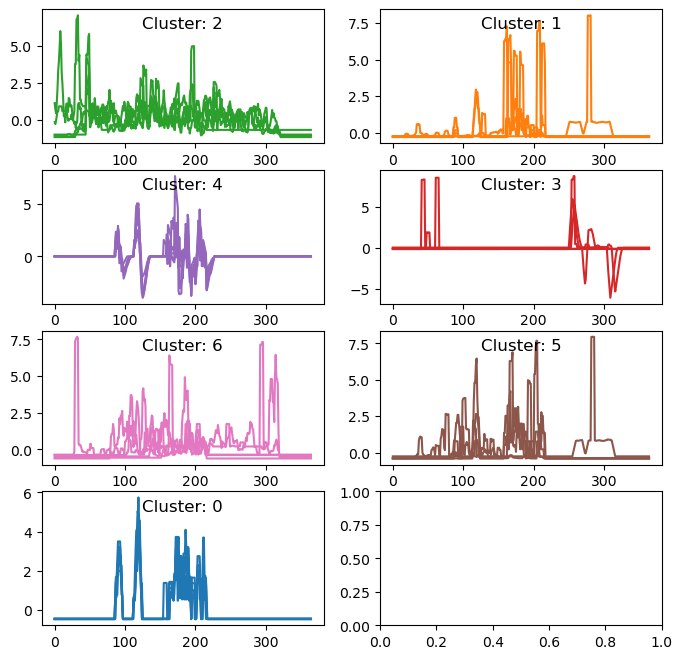

In [112]:
plot_timeseries_per_cluster(best_kmeans.labels_, best_n_clusters)

Feature based KMeans clustering seems to work well on the timeseries, clustering with good precision the ones with spikes in the same positions. It seems that it also separates in specific clusters the timeseries having negative spikes.

#### Hierachical

In [188]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata

Use both Z-score and minmax normalization.

In [189]:
scaler = StandardScaler()
X_std = scaler.fit_transform(timeseries_features)

In [190]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(timeseries_features)

##### With minmax normalization


In [191]:
config_hierarchical_minamx = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 0.35, n_clusters: 3

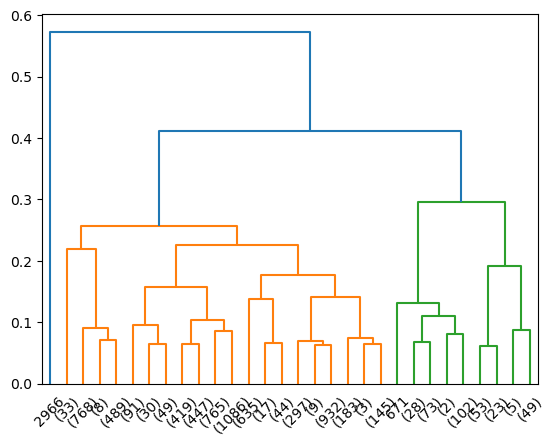

In [192]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=0.35, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.35, 'cosine', 'complete'))

method: ward, threshold: 2.0, n_clusters: 3

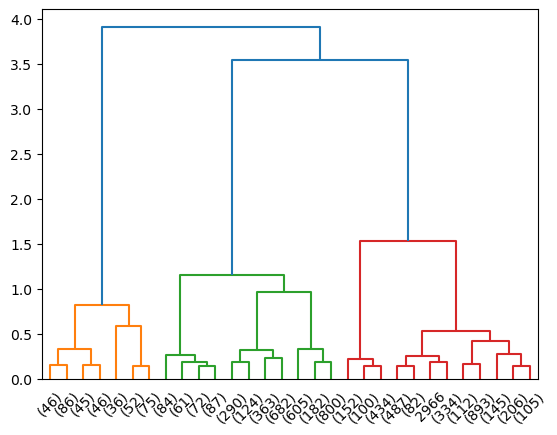

In [193]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=2.0, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((2.0, 'cosine', 'ward'))

method: average, threshold: 0.1, n_clusters: 3

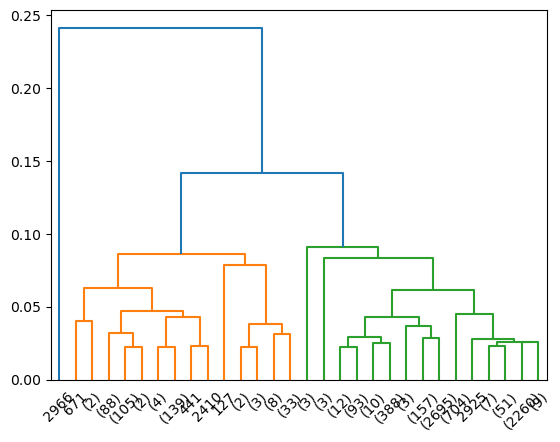

In [194]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.1, 'cosine', 'average'))

method: centroid, threshold: 0.1, n_clusters: 3

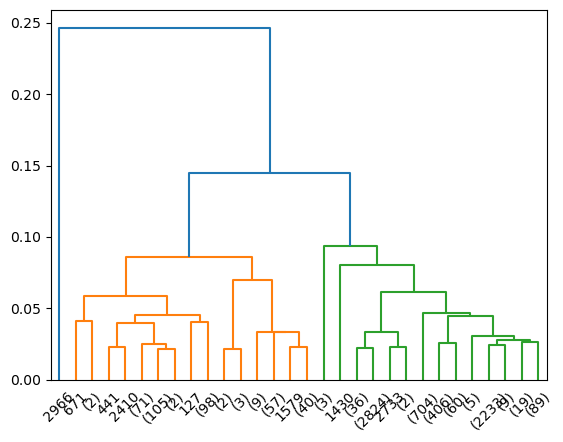

In [195]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.1, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [196]:
cluster_list_minmax = []
for treshold, metric_minmax, method_minmax in config_hierarchical_minamx:
    cluster = fclusterdata(X=X_minmax,
     t=treshold , criterion='distance', metric=metric_minmax, method=method_minmax)
     
    cluster_list_minmax.append(cluster)

Calculate Silhouette for each clustering.

In [197]:
for i, clustering in enumerate(cluster_list_minmax):
    treshold, metric, method = config_hierarchical_minamx[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_minmax, clustering)
    except:
        silhouette = np.nan
    print("MINMAX - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

MINMAX - dist: cosine , method: complete , SILHOUTTE: 0.47671200373359185 , n_clusters: 3
Clusters Size: [6450, 336, 1]


MINMAX - dist: cosine , method: ward , SILHOUTTE: 0.3987722241701328 , n_clusters: 3
Clusters Size: [386, 3350, 3051]


MINMAX - dist: cosine , method: average , SILHOUTTE: 0.4596390621521396 , n_clusters: 3
Clusters Size: [390, 6396, 1]


MINMAX - dist: cosine , method: centroid , SILHOUTTE: 0.45846510218701225 , n_clusters: 3
Clusters Size: [394, 6392, 1]




Now we show the timeseries for one of the minmax hierarchical clusterings that shows only 1 big cluster and 2 smaller ones. We choose the one with *centroid* method.

In [198]:
chosen_hierarc_minmax = np.array(cluster_list_minmax[3]) - 1
chosen_n_clusters = len(np.unique(chosen_hierarc_minmax))

(2, 2)


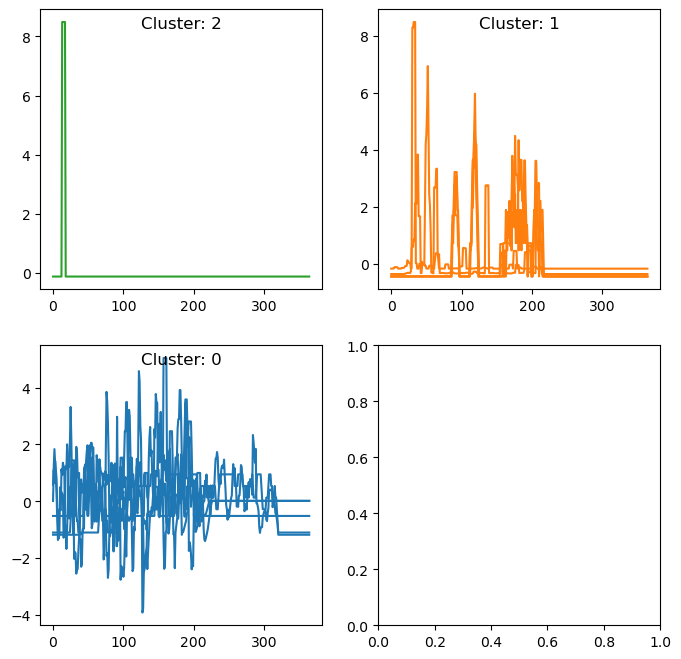

In [199]:
plot_timeseries_per_cluster(chosen_hierarc_minmax, chosen_n_clusters)

We can see that the timeseries in the bigger cluster have no negative values (no pits under 0) while the smaller one has negative peaks.

##### With mean-std normalization


In [200]:
config_hierarchical_std = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 1.65, n_clusters: 9

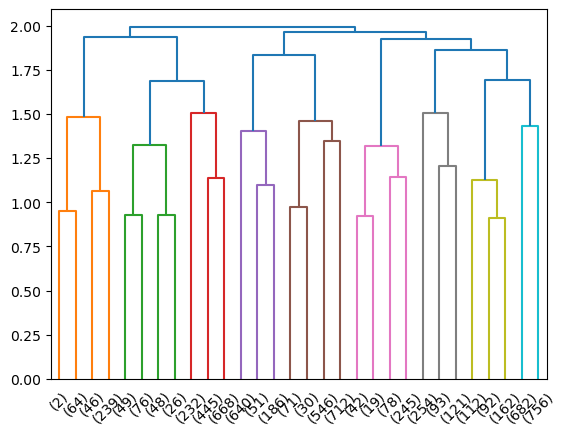

In [201]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=1.65, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((1.65, 'cosine', 'complete'))

method: ward, threshold: 14, n_clusters: 7

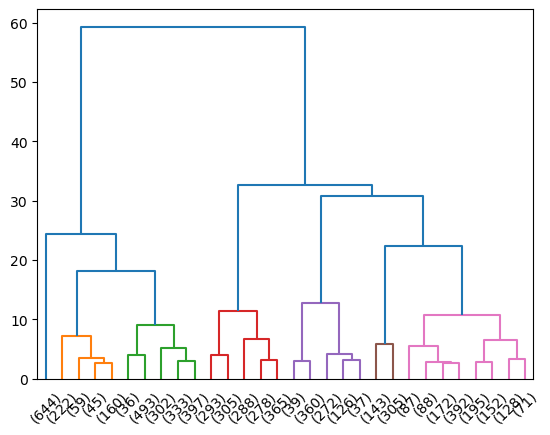

In [202]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=14, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((14, 'cosine', 'ward'))

method: average, threshold: 0.8, n_clusters: 5

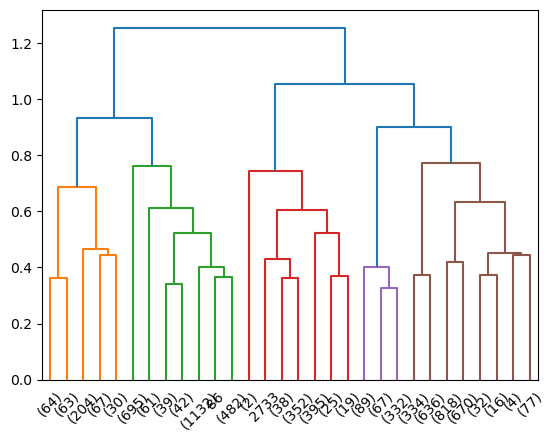

In [203]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.8, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.8, 'cosine', 'average'))

method: centroid, threshold: 0.7, n_clusters: 7

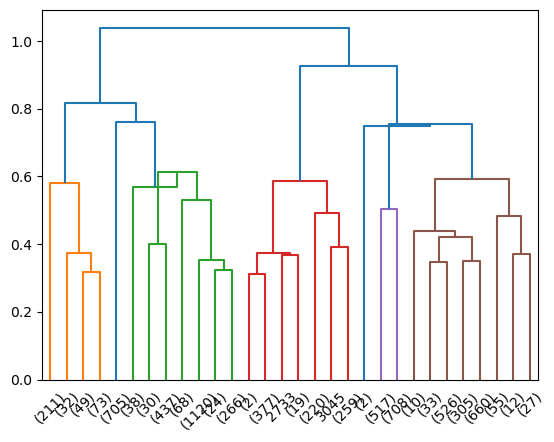

In [204]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.7, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.7, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [205]:
cluster_list_std = []
for treshold, metric_std, method_std in config_hierarchical_std:
    cluster = fclusterdata(X=X_std,
     t=treshold , criterion='distance', metric=metric_std, method=method_std)
     
    cluster_list_std.append(cluster)

Calculate Silhouette for each clustering.

In [206]:
for i, clustering in enumerate(cluster_list_std):
    treshold, metric, method = config_hierarchical_std[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_std, clustering)
    except:
        silhouette = np.nan
    print("STD - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

STD - dist: cosine , method: complete , SILHOUTTE: 0.1380786176966339 , n_clusters: 9
Clusters Size: [351, 199, 1345, 877, 1359, 384, 468, 366, 1438]


STD - dist: cosine , method: ward , SILHOUTTE: 0.2564560351816744 , n_clusters: 7
Clusters Size: [644, 486, 1561, 1529, 834, 448, 1285]


STD - dist: cosine , method: average , SILHOUTTE: 0.19454868097616196 , n_clusters: 5
Clusters Size: [428, 2452, 832, 488, 2587]


STD - dist: cosine , method: centroid , SILHOUTTE: 0.2574524005171416 , n_clusters: 7
Clusters Size: [365, 705, 1983, 879, 2, 1225, 1628]




The final chosen hierarchical cluster selected is the one with **ward** method and **minmax** normalization, as it has an appropriate number of clusters and elements for each clusters, a dendrogram with well distanciated branches and relatively higher Silhouette.

In [207]:
best_hierarchical = np.array(cluster_list_minmax[1]) - 1
best_n_clusters = len(np.unique(best_hierarchical))

We plot the timeseries for the hierarchical clustering with with **ward** method and **std** normalization.

(4, 2)


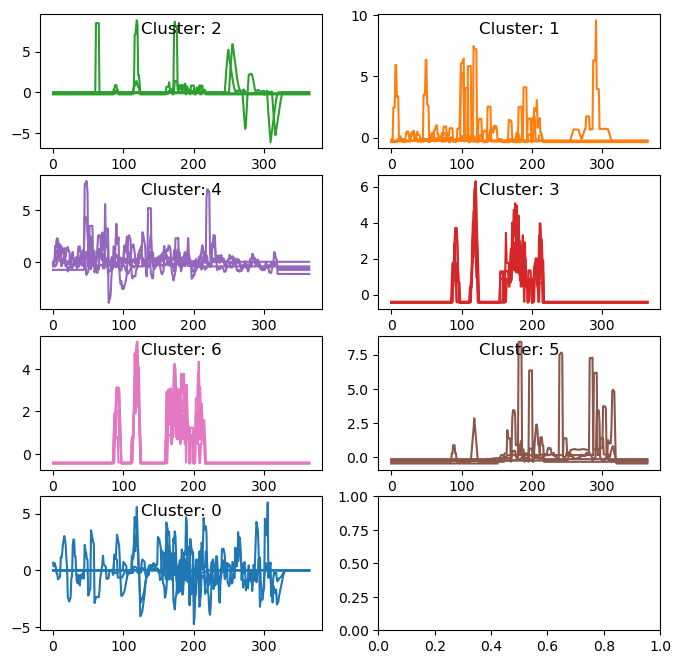

In [216]:
plot_timeseries_per_cluster(best_hierarchical, best_n_clusters)

Hierarchical seems to have clusters which have less coincidence in the positions of spikes, compared to KMeans. In particular cluster 0 seems to have many timeseries with negative spikes.

### Compression based clustering

In [217]:
from tslearn.piecewise import PiecewiseAggregateApproximation

We use PAA as the compression.

In [218]:
n_paa_segments = 27

paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(timeseries_data)

c:\Users\giaco\anaconda3\envs\PythonGPU\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Show PAA transformed timeseries

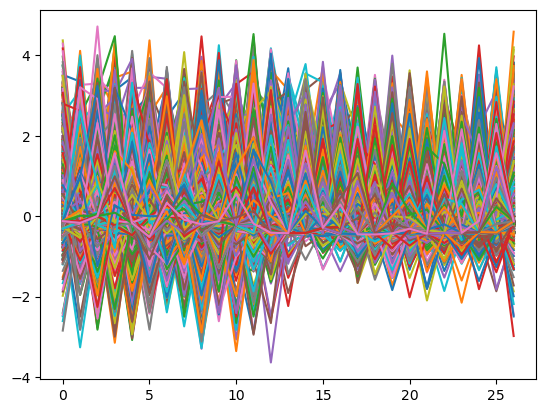

In [219]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [220]:
def TSKMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=5):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = TimeSeriesKMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value, random_state=0, metric='euclidean')
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [221]:
# Params for kmeans
clusters_list = [x for x in range(2, 21)]
init_value = 5
iter_value = 10

# Get list of kmeans with from the list of possible k
kmeans_list = TSKMeansFunction (X_minmax, clusters_list, init_value, iter_value)

# Calculate SSE for each kmeans
sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)

100%|██████████| 19/19 [05:51<00:00, 18.49s/it]

k =  2 | Clusters = [3309 3478] | Inertia = 0.11821032271534396
k =  3 | Clusters = [3177 3139  471] | Inertia = 0.08212644571415294
k =  4 | Clusters = [3113 2542  432  700] | Inertia = 0.062442407357880626
k =  5 | Clusters = [1964 1936 1832  695  360] | Inertia = 0.051005024972885706
k =  6 | Clusters = [1842 1855  497  286  694 1613] | Inertia = 0.04453394506659928
k =  7 | Clusters = [1268 1271  691  436  283 1640 1198] | Inertia = 0.04025998959277162
k =  8 | Clusters = [1036 1668  677  283  470  754 1342  557] | Inertia = 0.037307379717682235
k =  9 | Clusters = [ 477  898  671  283  376  744  960 1254 1124] | Inertia = 0.03447610600780919
k =  10 | Clusters = [ 479  892  671  279  376  707  955 1197 1075  156] | Inertia = 0.03209606758493821
k =  11 | Clusters = [ 430  835  671  277  376  587  894 1048  808  134  727] | Inertia = 0.03024781324614896
k =  12 | Clusters = [900 986 458 650 137 476 914 875 709 170 371 141] | Inertia = 0.028540094932027953
k =  13 | Clusters = [752 

Now we plot the SSE curve to help the choice of the best K.

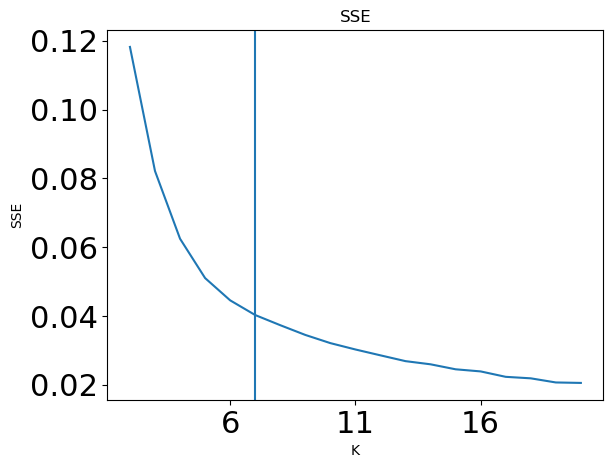

In [222]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(7)
plt.show()

The best K according to the SSE knee method is K=7

In [223]:
best_n_clusters = 7
best_kmeans = kmeans_list[best_n_clusters-2]

Now we show the timeseries for each cluster

(4, 2)


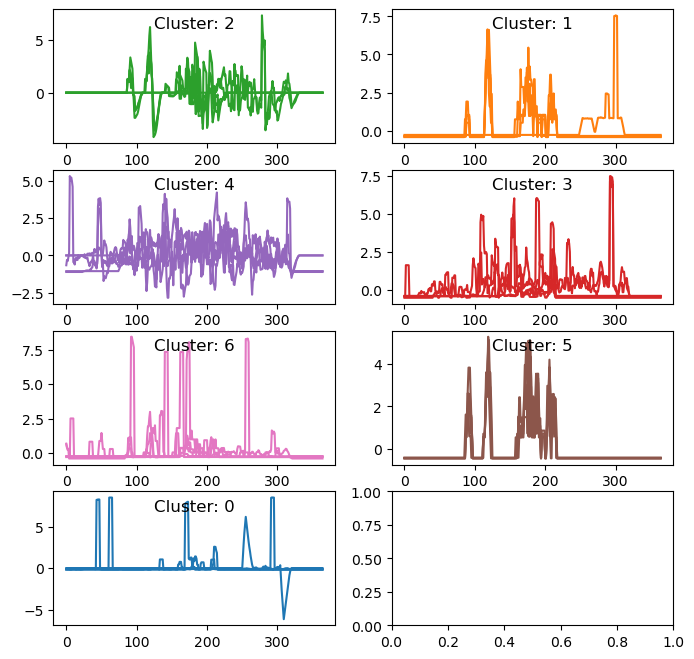

In [230]:
plot_timeseries_per_cluster(best_kmeans.labels_, best_n_clusters)

Clustering is similar to the one obtained with shape clustering, but some clusters (such as 4 and 3) seems to have less recognizable common patterns for the timeseries.

Show cluster centers for each cluster of the compressed timeseries next to the cluster means of the original timeseries.

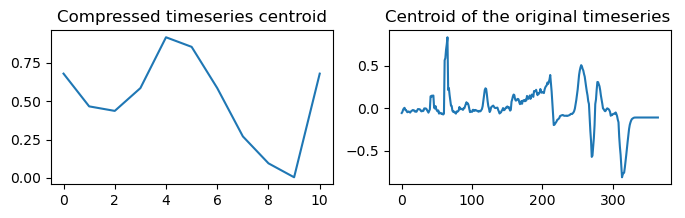

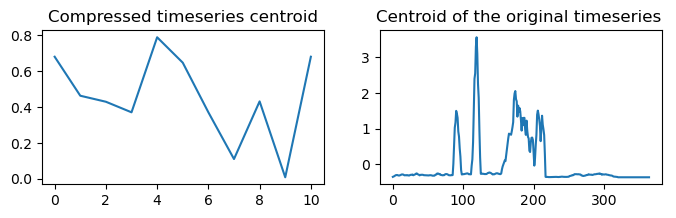

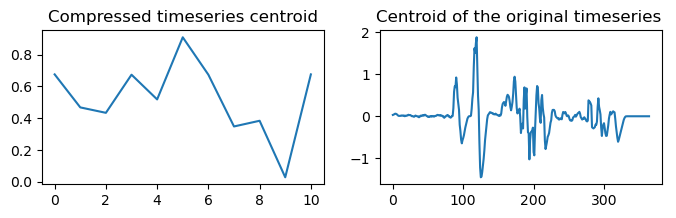

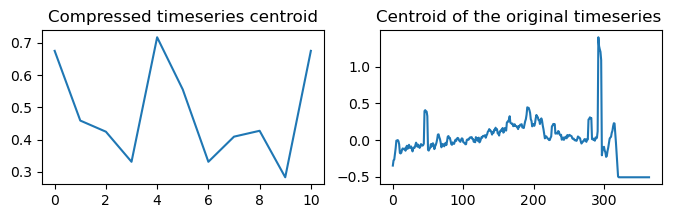

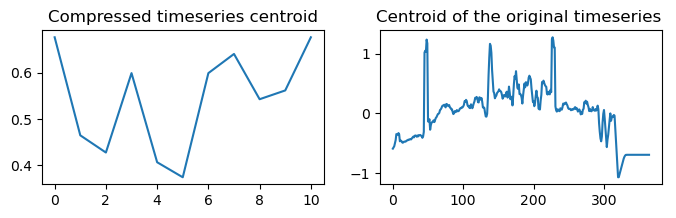

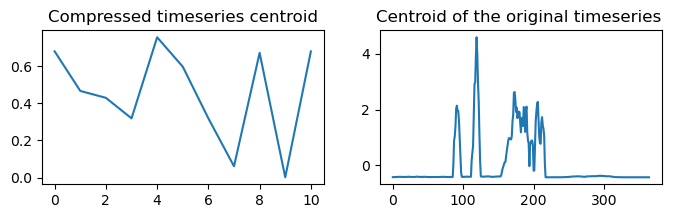

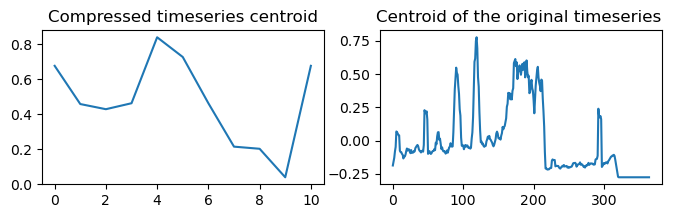

In [242]:
for c in range(best_n_clusters):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(best_kmeans.cluster_centers_[c])#.reshape(X_paa.shape[1], best_n_clusters))
    ax1.set_title("Compressed timeseries centroid")

    ax2.plot(np.mean(timeseries_data[np.where(best_kmeans.labels_ == c)], axis=0))
    ax2.set_title("Centroid of the original timeseries ")
    
    fig.set_size_inches(8, 2)
    plt.show()

It seems there is not much correspondance between PAA timeseries centroid and average cluster of the original timeseries.

## Shapelets

In [226]:
from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax

In [228]:
user_2019_bot.head()

NameError: name 'user_2019_bot' is not defined

Get labels of each timeseries

In [ ]:
labels = np.transpose(user_2019_bot.values)

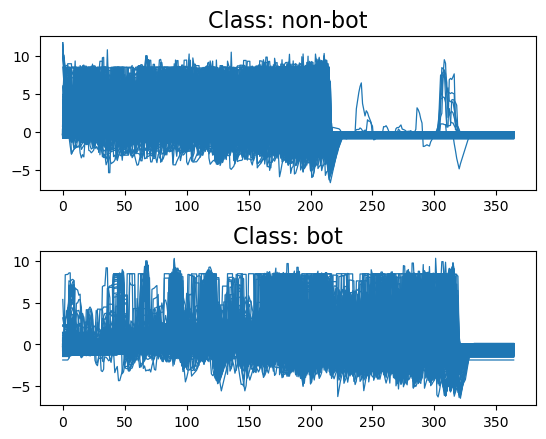

In [ ]:
plt.figure()
for i, classe in enumerate(['non-bot', 'bot']):
    plt.subplot(2, 1, i + 1)
    mask = labels == i
    for x in timeseries_data[mask[0]]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)
    

plt.subplots_adjust(hspace=0.4)

plt.show()

Use grabocka method to identify the number of shapelets for each shapelet size

In [ ]:
n_ts, ts_sz = timeseries_data.shape
n_classes = 2

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.01,
                                                       r=5)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 6787
ts_sz 365
n_classes 2
shapelet_sizes {3: 6, 6: 6, 9: 6, 12: 6, 15: 6}


Drop the shapelets with size 3 because they are too small

In [ ]:
shapelet_sizes.pop(3)
print('shapelet_sizes', shapelet_sizes)

shapelet_sizes {6: 6, 9: 6, 12: 6, 15: 6}


Build the shapelet model to extract shapelet. We use shapelet sizes and numbers from previous grabocka method.

In [ ]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\tslearn\shapelets\shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


In [ ]:
labels = labels.reshape(labels.shape[1])
print(labels.shape)

(6787,)


Fit the shapelet model

In [ ]:
shp_clf.fit(timeseries_data, labels)

Epoch 1/200
27/27 [==============================] - 5s 115ms/step - loss: 0.9897 - binary_accuracy: 0.4307 - binary_crossentropy: 0.9734
Epoch 2/200
27/27 [==============================] - 3s 116ms/step - loss: 0.7820 - binary_accuracy: 0.4372 - binary_crossentropy: 0.7671
Epoch 3/200
27/27 [==============================] - 3s 112ms/step - loss: 0.7120 - binary_accuracy: 0.5070 - binary_crossentropy: 0.6976
Epoch 4/200
27/27 [==============================] - 3s 117ms/step - loss: 0.6837 - binary_accuracy: 0.5975 - binary_crossentropy: 0.6695
Epoch 5/200
27/27 [==============================] - 3s 115ms/step - loss: 0.6716 - binary_accuracy: 0.6330 - binary_crossentropy: 0.6575
Epoch 6/200
27/27 [==============================] - 3s 120ms/step - loss: 0.6665 - binary_accuracy: 0.6330 - binary_crossentropy: 0.6524
Epoch 7/200
27/27 [==============================] - 3s 118ms/step - loss: 0.6635 - binary_accuracy: 0.6330 - binary_crossentropy: 0.6495
Epoch 8/200
27/27 [===============

LearningShapelets(max_iter=200, n_shapelets_per_size={6: 6, 9: 6, 12: 6, 15: 6},
                  verbose=1, weight_regularizer=0.01)

In [ ]:
predicted_labels = shp_clf.predict(timeseries_data)
print("Correct classification rate:", accuracy_score(labels, predicted_labels))
predicted_locations = shp_clf.locate(timeseries_data)

27/27 [==============================] - 1s 12ms/step
Correct classification rate: 0.6820391925740386
27/27 [==============================] - 1s 8ms/step


Print all the shapelets

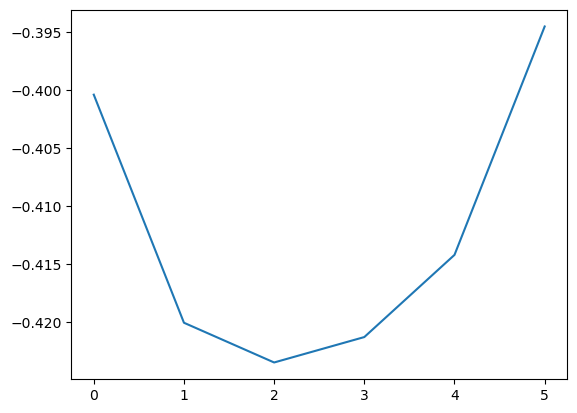

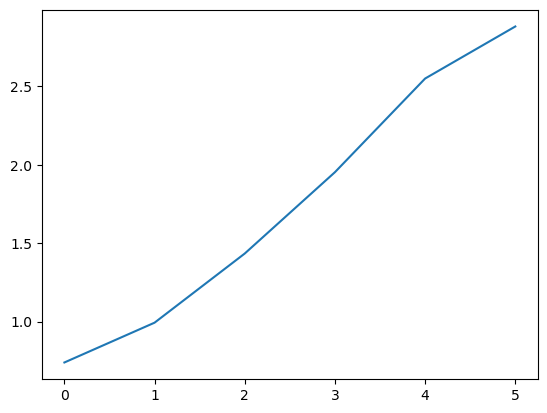

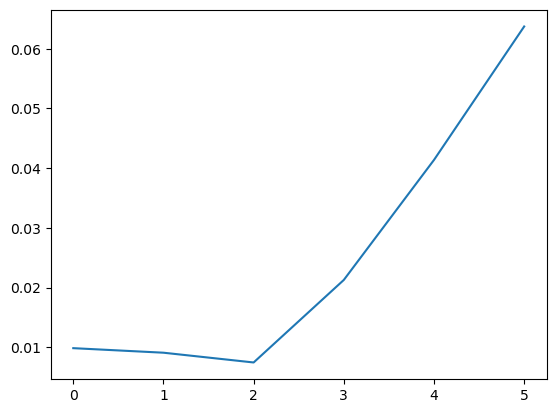

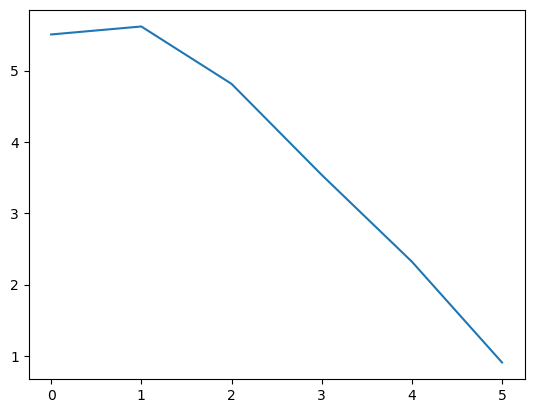

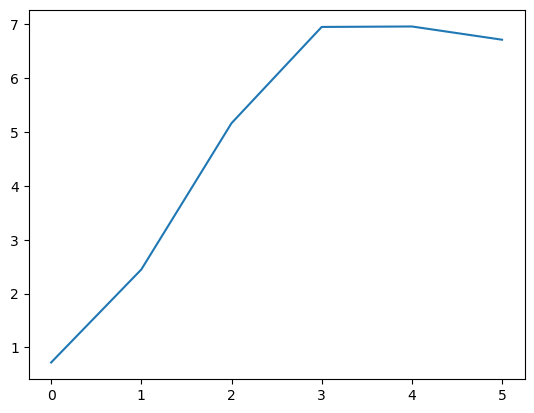

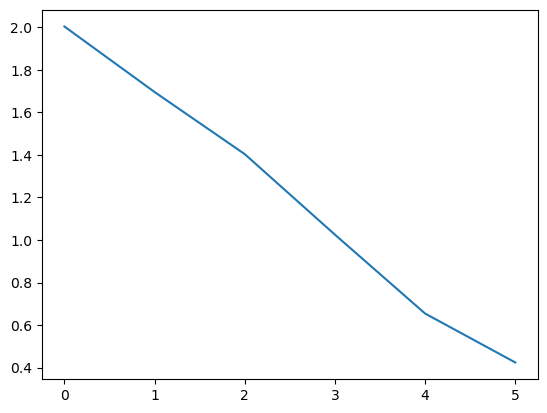

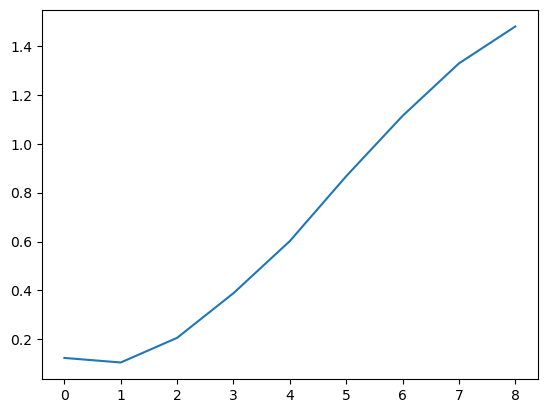

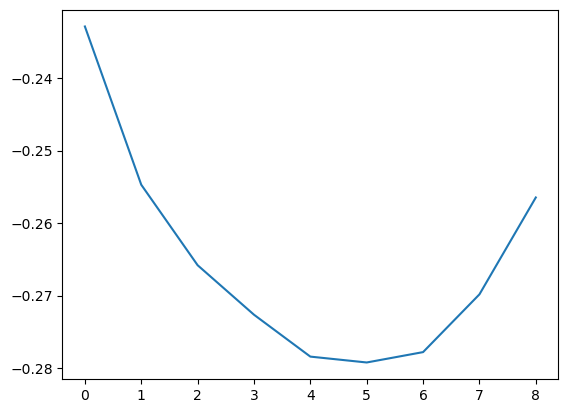

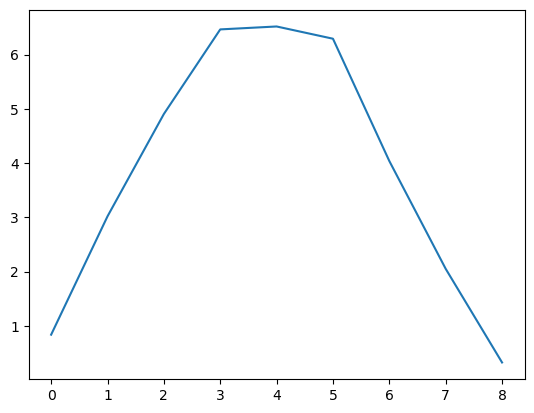

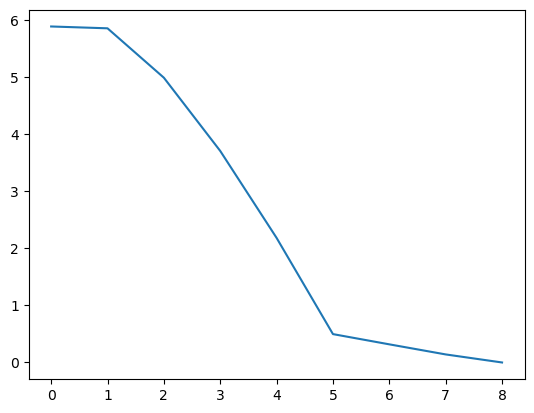

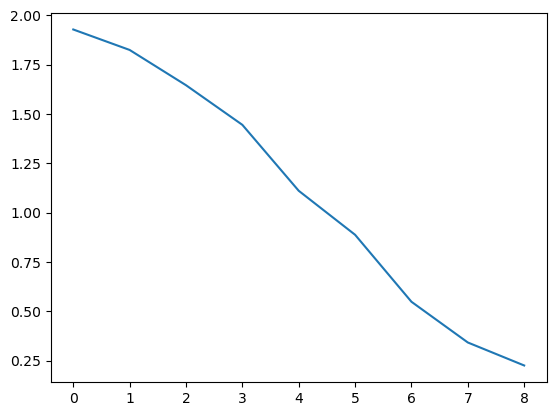

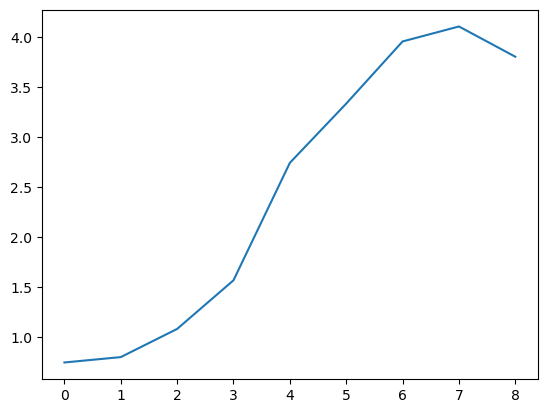

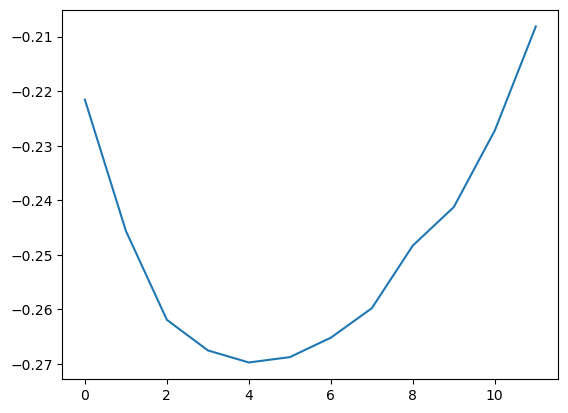

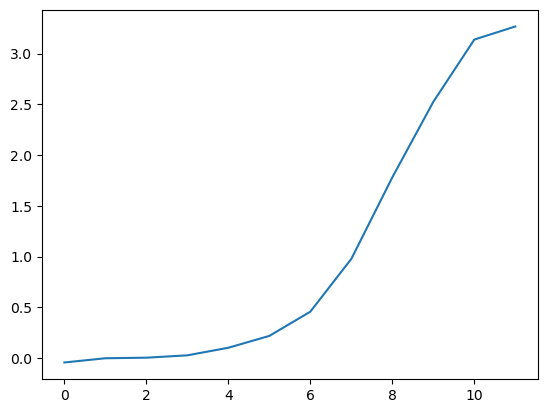

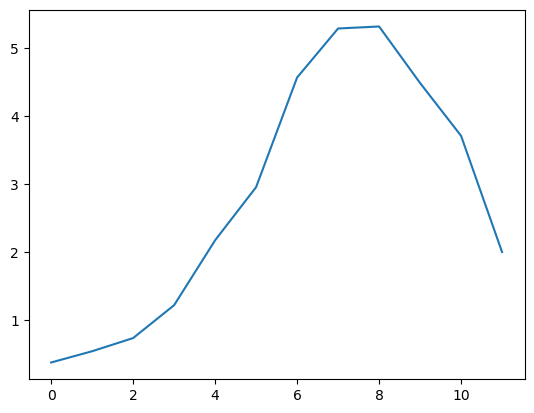

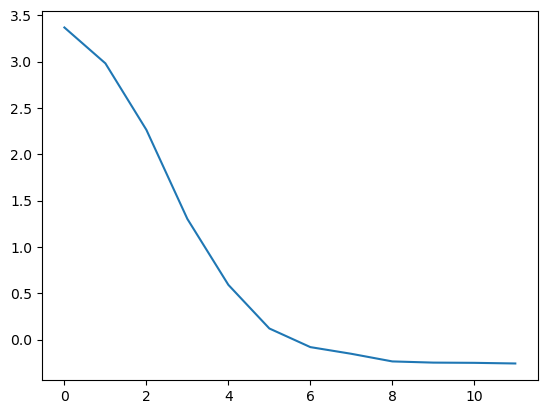

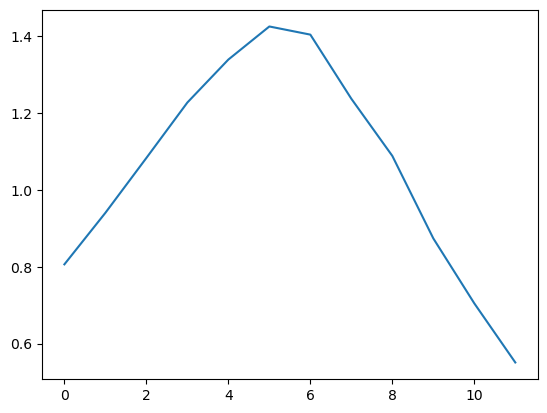

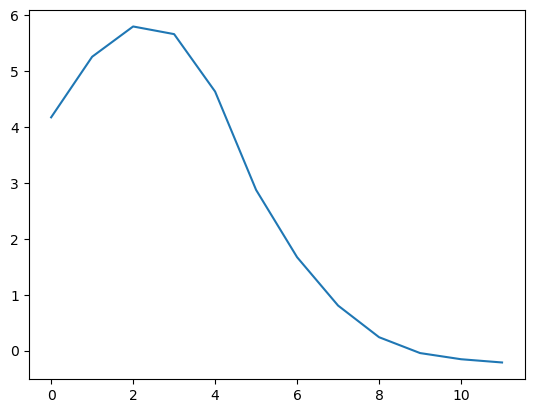

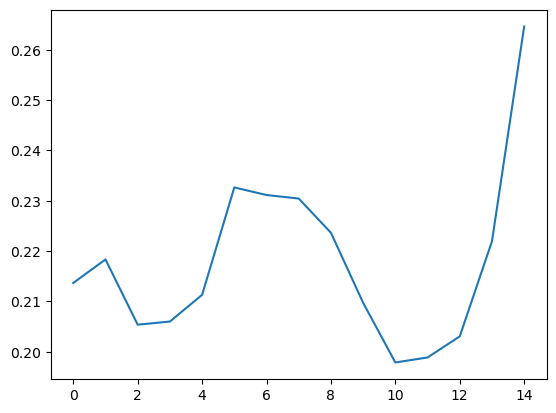

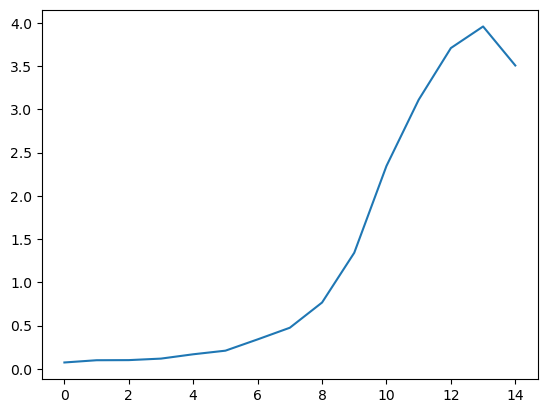

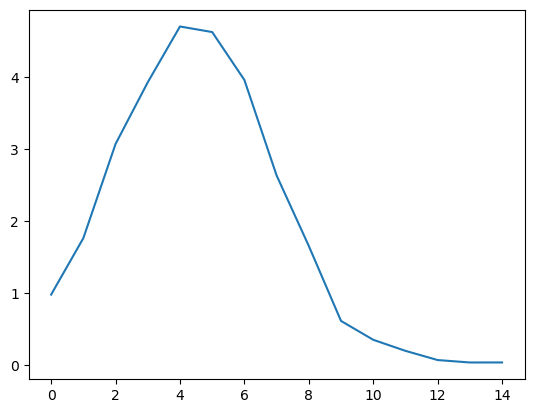

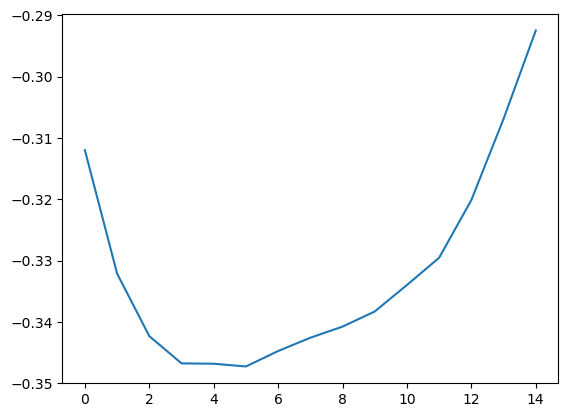

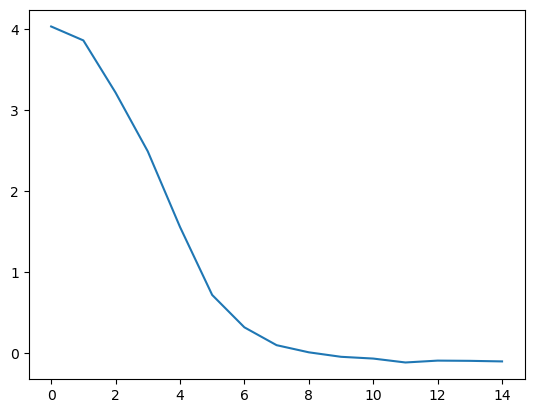

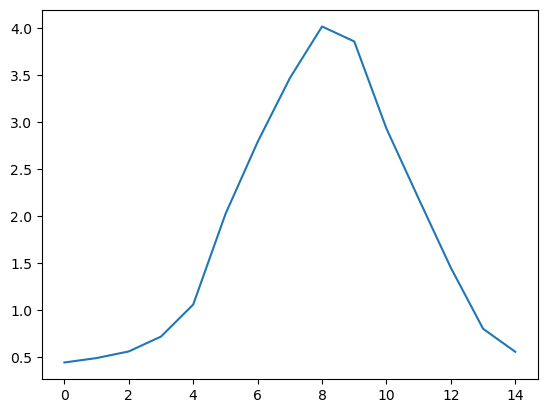

In [ ]:
len(shp_clf.shapelets_)
for shp in shp_clf.shapelets_:
    plt.plot(shp)
    plt.show()

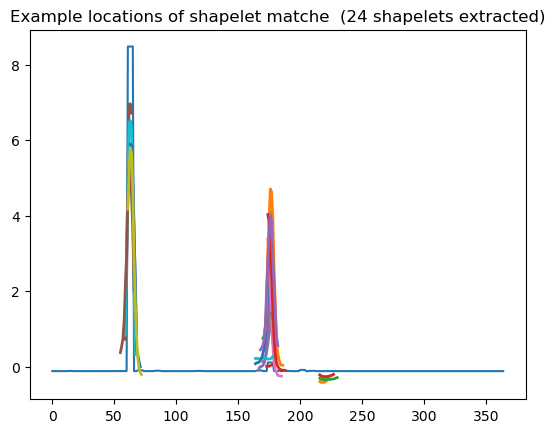

In [ ]:
ts_id = 88
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matche  ({} shapelets extracted)".format(n_shapelets))

plt.plot(timeseries_data[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
plt.show()